**Mount Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Dataset Path & Project Folders**

In [3]:

DATA_DIR = "/content/drive/MyDrive/AIML/brain_tumor_dataset"


OUT_DIR = "/content/drive/MyDrive/AIML/resized_images"
VIS_DIR = "/content/drive/MyDrive/AIML/eda_visualizations"

import os
for d in [OUT_DIR, VIS_DIR]:
    os.makedirs(d, exist_ok=True)

print("Dataset path:", DATA_DIR)
print("Output path:", OUT_DIR)


Dataset path: /content/drive/MyDrive/AIML/brain_tumor_dataset
Output path: /content/drive/MyDrive/AIML/resized_images


**Imports**

In [4]:
import os, glob, random
from pathlib import Path
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


**Explore Dataset – Classes & Counts**

Classes: ['Testing', 'Training']


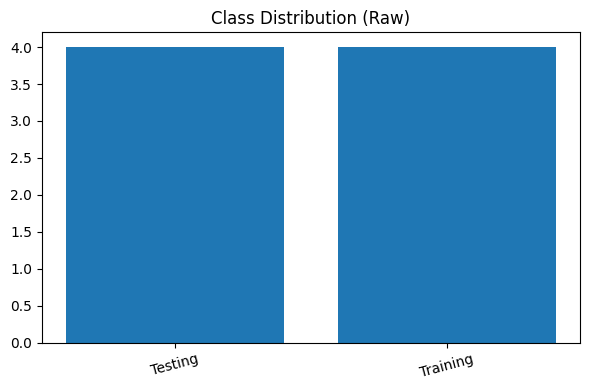

In [5]:
classes = sorted([d for d in os.listdir(DATA_DIR) if (Path(DATA_DIR)/d).is_dir()])
print("Classes:", classes)


counts = {c: len(glob.glob(f"{DATA_DIR}/{c}/*")) for c in classes}
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.title("Class Distribution (Raw)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig(f"{VIS_DIR}/IT24103807_class_dist_raw.png")
plt.show()


**EDA – Original Sizes & Aspect Ratios**

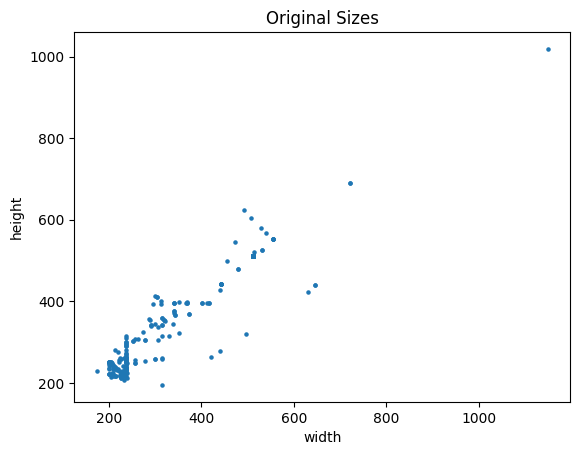

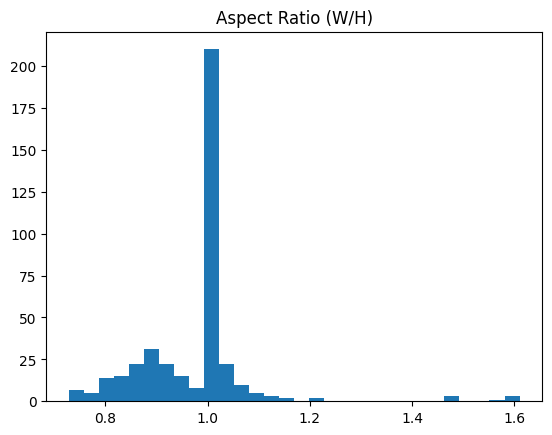

In [7]:
wh = []
# Update the glob pattern to look for files within subdirectories
for c in classes:
    # Assuming the subdirectories are within the main class directories like 'Testing/no_tumor', 'Training/tumor', etc.
    # This pattern looks for all files within two levels of subdirectories under DATA_DIR
    for p in glob.glob(f"{DATA_DIR}/{c}/*/*")[:200]:
        with Image.open(p) as im:
            wh.append(im.size)  # (w,h)
wh = np.array(wh)

# scatter
plt.scatter(wh[:,0], wh[:,1], s=5)
plt.xlabel("width"); plt.ylabel("height")
plt.title("Original Sizes")
plt.savefig(f"{VIS_DIR}/IT24103807_size_scatter_before.png")
plt.show()

# aspect ratio
ar = wh[:,0]/np.maximum(wh[:,1],1)
plt.hist(ar, bins=30)
plt.title("Aspect Ratio (W/H)")
plt.savefig(f"{VIS_DIR}/IT24103807_aspect_ratio_hist_before.png")
plt.show()

**Resizing Function (Letterbox)**

In [8]:
TARGET = (224, 224)
PAD_VALUE = 128

def load_gray(path):
    with Image.open(path) as im:
        return np.array(im.convert("L"))

def resize_letterbox(img, target=TARGET, pad_val=PAD_VALUE):
    h, w = img.shape[:2]
    tw, th = target
    scale = min(tw/w, th/h)
    nw, nh = int(round(w*scale)), int(round(h*scale))
    interp = cv2.INTER_AREA if scale < 1.0 else cv2.INTER_CUBIC
    resized = cv2.resize(img, (nw, nh), interpolation=interp)
    top = (th-nh)//2; bottom = th-nh-top
    left = (tw-nw)//2; right = tw-nw-left
    out = np.full((th, tw), pad_val, dtype=np.uint8)
    out[top:top+nh, left:left+nw] = resized
    return out


**Batch Resizing**

In [10]:
for c in classes:
    Path(f"{OUT_DIR}/{c}").mkdir(parents=True, exist_ok=True)

for c in classes:
    # Update the glob pattern to look for files within subdirectories
    for p in glob.glob(f"{DATA_DIR}/{c}/*/*"):
        img = load_gray(p)
        out = resize_letterbox(img)
        # Preserve the subdirectory structure in the output directory
        relative_path = Path(p).relative_to(f"{DATA_DIR}/{c}")
        output_path = Path(f"{OUT_DIR}/{c}") / relative_path
        output_path.parent.mkdir(parents=True, exist_ok=True)
        cv2.imwrite(str(output_path), out)

print("Resized images saved in:", OUT_DIR)

Resized images saved in: /content/drive/MyDrive/AIML/resized_images


**!pip install mplcyberpunk**

In [11]:
check_paths = glob.glob(f"{OUT_DIR}/**/*", recursive=True)
print("Example resized file:", check_paths[0])

# quick check
sizes = []
for p in random.sample(check_paths, min(200,len(check_paths))):
    with Image.open(p) as im:
        sizes.append(im.size)
print("Unique sizes after resizing:", set(sizes))


Example resized file: /content/drive/MyDrive/AIML/resized_images/Testing
Unique sizes after resizing: {(224, 224)}


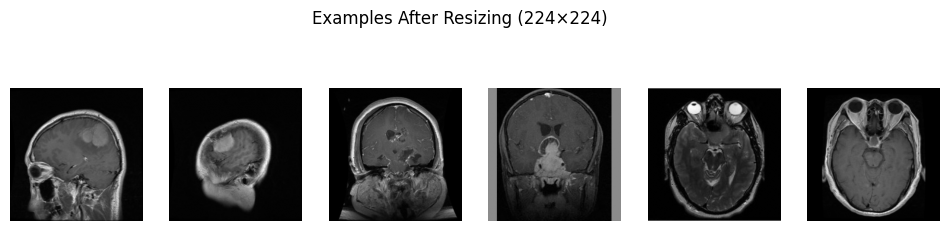

In [12]:
# montage
sel = random.sample(check_paths, 6)
fig, axes = plt.subplots(1,6, figsize=(12,3))
for i,p in enumerate(sel):
    with Image.open(p) as im:
        axes[i].imshow(im, cmap="gray")
        axes[i].axis("off")
plt.suptitle("Examples After Resizing (224×224)")
plt.savefig(f"{VIS_DIR}/IT24103807_resized_examples.png")
plt.show()
